## Preparation

Datasets:
- https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small
- https://www.kaggle.com/datasets/landrykezebou/vcor-vehicle-color-recognition-dataset
- https://www.kaggle.com/datasets/imoore/6000-store-items-images-classified-by-color (Digikala)

In [1260]:
try: from tensorflow import keras
except ImportError: import keras
import plotly.io as pio
import tensorflow as tf

# Disable interactive visualization
# Requires kaleido and nbformat
pio.renderers.default = 'svg'
pio.templates.default = 'plotly_dark'

# Set seed for possible reproducibility
# Affect Python, Numpy, and Keras
keras.utils.set_random_seed(1337)

#  Check available GPU for TensorFlow
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Extract Zip Files

In [1261]:
import os
import glob
import shutil
import zipfile

# Follow Kaggle directory structures
# Input should be read only after extraction
input_dir = 'input'
misc_dir = 'misc'

# Dataset folders
data1_dir = f'{input_dir}/fashion-product-images-small'
data2_dir = f'{input_dir}/vcor-vehicle-color-recognition-dataset'
data3_dir = f'{input_dir}/digikala-color-classification'

def extract_multi_zips(base_zip_name: str, in_dir: str, out_dir: str, check_out_dir = False):
    # Combine multiple zips onto a single zip
    with open(f'{in_dir}/{base_zip_name}.zip', 'wb') as zip_final:
        for zip_part in glob.glob(f'{in_dir}/{base_zip_name}.zip.*'):
            with open(zip_part, 'rb') as f:
                shutil.copyfileobj(f, zip_final)

    # Don't extract if output directory already exist
    if check_out_dir and os.path.exists(out_dir): return
    # Extract the previously combined zip to output directory
    with zipfile.ZipFile(f'{input_dir}/{base_zip_name}.zip') as zip:
        zip.extractall(out_dir)

# extract_multi_zips('data1', input_dir, data1_dir, True)
# extract_multi_zips('data2', input_dir, data2_dir, True)
# extract_multi_zips('data3', input_dir, data3_dir, True)

### Read Data from the First Dataset

In [1262]:
import pandas as pd

def join_last_cols(cols):
    # More columns detected due to comma in string
    if len(cols) > len(headers):
        for i in range(len(headers), len(cols)):
            # Get index of last valid column
            last_col = len(headers) - 1
            # Combine every string after last column
            cols[last_col] = cols[last_col] + ',' + cols[i]
    # Slice invalid columns after combining string
    return cols[:len(headers)]

# Get header list first to mitigate bad columns when reading CSV
headers = list(pd.read_csv(f'{data1_dir}/styles.csv', nrows = 0).columns)
df1 = pd.read_csv(f'{data1_dir}/styles.csv', on_bad_lines = join_last_cols, engine = 'python')
del headers

df1.head(1)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt


In [1263]:
# Add image path as column
df1['image'] = f'{data1_dir}/images/' + df1['id'].astype(str) + '.jpg'
df1.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,input/fashion-product-images-small/images/1597...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,input/fashion-product-images-small/images/3938...
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,input/fashion-product-images-small/images/5926...
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,input/fashion-product-images-small/images/2137...
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,input/fashion-product-images-small/images/5375...


There are many columns, but to develop a prediction model, perhaps the most important ones are `articleType` and `baseColour`.

Since I'm going to reuse the model as recommender system, I think `baseColour` is more relevant. We can also combine it with other dataset since color is a universal standard.

### Read Data from the Second Dataset
Additional datasets are needed since the model accuracy is still too low if only using the first dataset.

In [1264]:
list_colors = []
list_images = []

for color in os.listdir(data2_dir):
    # Subdir should be a color name (as folder)
    subdir = f'{data2_dir}/{color}'

    if not os.path.isfile(subdir):
        for file in os.listdir(subdir):

            # File path should be an image
            file_path = f'{subdir}/{file}'

            if os.path.isfile(file_path):
              list_images.append(file_path)
              list_colors.append(color.title())

df2 = pd.DataFrame({
    'baseColour': list_colors,
    'image': list_images
})

del list_colors
del list_images

df2.head()

,baseColour,image
0,Beige,input/vcor-vehicle-color-recognition-dataset/b...
1,Beige,input/vcor-vehicle-color-recognition-dataset/b...
2,Beige,input/vcor-vehicle-color-recognition-dataset/b...
3,Beige,input/vcor-vehicle-color-recognition-dataset/b...
4,Beige,input/vcor-vehicle-color-recognition-dataset/b...


### Read Data from the Thrid Dataset
The third dataset also includes test images, but there is no label so it can't be used as validation data.

In [1265]:
list_colors = []
list_images = []

for color in os.listdir(f'{data3_dir}/train'):
    # Subdir should be a color name (as folder)
    subdir = f'{data3_dir}/train/{color}'

    if not os.path.isfile(subdir):
        for file in os.listdir(subdir):

            # File path should be an image
            file_path = f'{subdir}/{file}'

            if os.path.isfile(file_path):
              list_images.append(file_path)
              list_colors.append(color.title())

df3 = pd.DataFrame({
    'baseColour': list_colors,
    'image': list_images
})

del list_colors
del list_images

df3.head()

,baseColour,image
0,Black,input/digikala-color-classification/train/blac...
1,Black,input/digikala-color-classification/train/blac...
2,Black,input/digikala-color-classification/train/blac...
3,Black,input/digikala-color-classification/train/blac...
4,Black,input/digikala-color-classification/train/blac...


In [1266]:
# Combine all datasets
df = pd.concat([df1, df2, df3])

## Simple EDA

### See Color Distribution

Total colors: 46


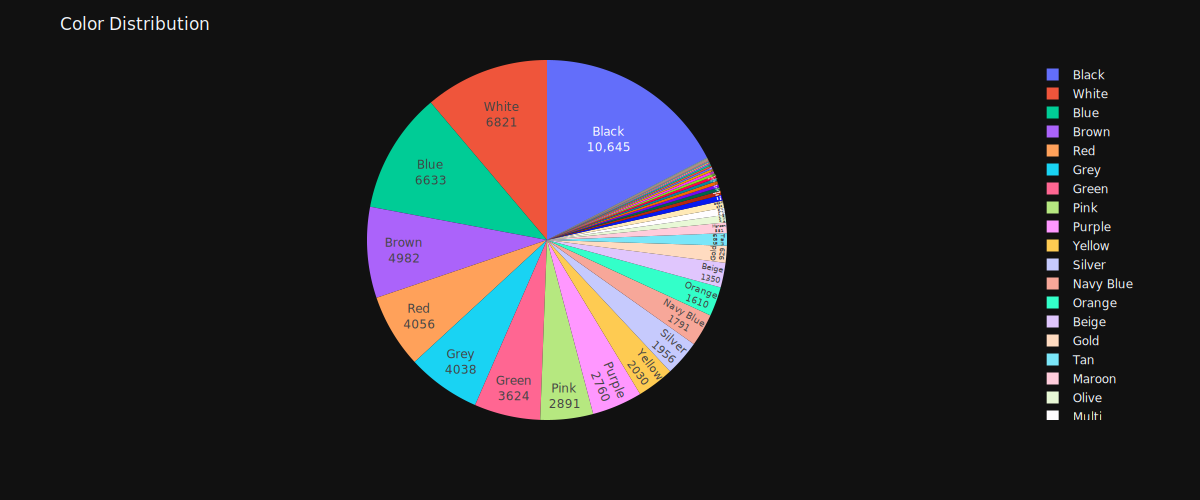

In [1267]:
import plotly.express as px

temp = df['baseColour'].value_counts()
print('Total colors:', len(temp))

fig = px.pie(temp, names = temp.index, values = temp.values)
fig.update_traces(textposition = 'inside', textinfo = 'label+value')
fig.update_layout(title = 'Color Distribution')
fig.show(width = 1200)

### Filter the Top N Colors
Since there might be to many colors, we can filter only the top N colors from both dataset. This may also increase model accuracy by reducing false positives.

In [1268]:
top_colors = 20

df1_colors = df1['baseColour'].value_counts()[:top_colors].index
df2_colors = df2['baseColour'].value_counts()[:top_colors].index
df3_colors = df3['baseColour'].value_counts()[:top_colors].index

print(df1_colors)
print(df2_colors)
print(df3_colors)

Index(['Black', 'White', 'Blue', 'Brown', 'Grey', 'Red', 'Green', 'Pink',
       'Navy Blue', 'Purple', 'Silver', 'Yellow', 'Beige', 'Gold', 'Maroon',
       'Orange', 'Olive', 'Multi', 'Cream', 'Steel'],
      dtype='object', name='baseColour')
Index(['Blue', 'Red', 'Yellow', 'Brown', 'Green', 'Purple', 'Orange', 'Pink',
       'Grey', 'Beige', 'Black', 'White', 'Tan', 'Silver', 'Gold'],
      dtype='object', name='baseColour')
Index(['White', 'Green', 'Red', 'Grey', 'Brown', 'Blue', 'Yellow', 'Purple',
       'Silver', 'Pink', 'Black', 'Orange'],
      dtype='object', name='baseColour')


In [1269]:
colors_all = set([*df1_colors, *df2_colors, *df3_colors])
print(f'All top {top_colors} colors:', colors_all)

All top 20 colors: {'Navy Blue', 'Olive', 'Cream', 'Blue', 'Pink', 'Multi', 'White', 'Tan', 'Grey', 'Gold', 'Silver', 'Purple', 'Maroon', 'Red', 'Green', 'Brown', 'Orange', 'Beige', 'Steel', 'Yellow', 'Black'}


In [1270]:
colors_diff = []

for i in colors_all:
    if any([
        i not in df1_colors.to_list(),
        i not in df2_colors.to_list(),
        i not in df3_colors.to_list()
    ]):
        colors_diff.append(i)

# See colors that only exist on one dataset
print('Non-shared colors:', colors_diff)

del df1_colors
del df2_colors
del df3_colors

del colors_all
del colors_diff

Non-shared colors: ['Navy Blue', 'Olive', 'Cream', 'Multi', 'Tan', 'Gold', 'Maroon', 'Beige', 'Steel']


### Combine/Drop Ambiguous Colors

In [1271]:
# Combine less known colors (less aggresive)
df['baseColour'] = df['baseColour'].str.replace('Olive', 'Beige')
df['baseColour'] = df['baseColour'].str.replace('Cream', 'Beige')
df['baseColour'] = df['baseColour'].str.replace('Steel', 'Silver')
df['baseColour'] = df['baseColour'].str.replace('Tan', 'Beige')

# Combine popular colors (more aggresive)
df['baseColour'] = df['baseColour'].str.replace('Navy Blue', 'Blue')
df['baseColour'] = df['baseColour'].str.replace('Maroon', 'Red')
df['baseColour'] = df['baseColour'].str.replace('Beige', 'Brown')
df['baseColour'] = df['baseColour'].str.replace('Gold', 'Yellow')
df['baseColour'] = df['baseColour'].str.replace('Silver', 'Grey')

df = df[df['baseColour'] != 'Multi']

In [1272]:
print(df['baseColour'].unique())

['Blue' 'Grey' 'Black' 'Green' 'Purple' 'White' 'Brown' 'Bronze' 'Teal'
 'Copper' 'Pink' 'Off White' 'Red' 'Khaki' 'Orange' 'Coffee Brown'
 'Yellow' 'Charcoal' 'Magenta' 'Lavender' 'Sea Green' 'Peach' 'Skin'
 'Burgundy' 'Grey Melange' 'Rust' 'Rose' 'Lime Green' 'Mauve'
 'Turquoise Blue' 'Metallic' 'Mustard' 'Taupe' 'Nude' 'Mushroom Brown' nan
 'Fluorescent Green']


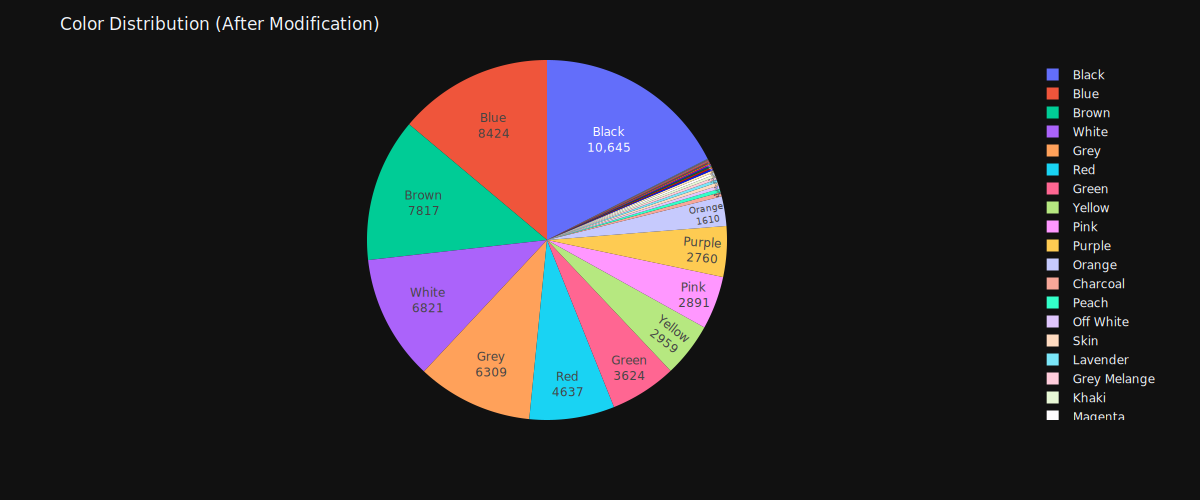

In [1273]:
# See the color distribution again
temp = df['baseColour'].value_counts()
fig = px.pie(temp, names = temp.index, values = temp.values)
fig.update_traces(textposition = 'inside', textinfo = 'label+value')
fig.update_layout(title = 'Color Distribution (After Modification)')
fig.show(width = 1200)

**NOTE:** The graph above still includes the non top-N colors, they will be filtered after this.

## Other Preprocessing

In [1274]:
# Mark image and label column
x_col = 'image'
y_col = 'baseColour'

### Drop Null Values
Since we are going to use images (CV) rather than texts (NLP), null values can be ignored except for the label column. 

In [1275]:
print(df.isna().sum())
df = df.dropna(subset = [y_col])

id                    16612
gender                16612
masterCategory        16612
subCategory           16612
articleType           16612
baseColour               15
season                16633
year                  16613
usage                 16929
productDisplayName    16619
image                     0
dtype: int64


### Drop Minority Classes

As we already seen on the previous graph, the class distribution is not balanced. To reduce error rate caused by insufficient samples, we can also filter the dataframe so that each class should have at least 1000 samples.

In [1276]:
temp = df[y_col].value_counts()[:top_colors]
del top_colors

temp

baseColour
Black           10645
Blue             8424
Brown            7817
White            6821
Grey             6309
Red              4637
Green            3624
Yellow           2959
Pink             2891
Purple           2760
Orange           1610
Charcoal          228
Peach             195
Off White         182
Skin              179
Lavender          162
Grey Melange      146
Khaki             139
Magenta           129
Teal              120
Name: count, dtype: int64

The last class that has at least 1000 samples is "Orange" (at position 11).

In [1277]:
df = df[df['baseColour'].isin(temp.index[:11])]
df['baseColour'].unique()

array(['Blue', 'Grey', 'Black', 'Green', 'Purple', 'White', 'Brown',
       'Pink', 'Red', 'Orange', 'Yellow'], dtype=object)

## Image Augmentation

In [1278]:
from PIL import Image
import numpy as np

def view_image_data(file_path):
    with Image.open(file_path) as image:
        print(f'Path: {file_path}')
        print(f'Image Format: {image.format}')
        print(f'Color Format: {image.mode}')
        print(f'Color Depth: {np.asarray(image).dtype}')
        print(f'Shape: {np.asarray(image).shape}\n')

temp = f'{data1_dir}/images/' + os.listdir(f'{data1_dir}/images')[0]
view_image_data(temp)

temp = f'{data2_dir}/beige/' + os.listdir(f'{data2_dir}/beige')[0]
view_image_data(temp)

Path: input/fashion-product-images-small/images/10000.jpg
Image Format: JPEG
Color Format: RGB
Color Depth: uint8
Shape: (80, 60, 3)

Path: input/vcor-vehicle-color-recognition-dataset/beige/00ecfeedea.jpg
Image Format: JPEG
Color Format: RGB
Color Depth: uint8
Shape: (266, 430, 3)



Since the image shapes are not uniform/square, not all augmentations can be used (e.g. no rotate 90). We can make it square first and resize it to a uniform size before applying more augmentations.

**EDIT:** It seems that the image shape must be the same as specified for `flow_from_directory`, so changing the size after that will cause a missmatch error. Not used for now until I find a clean workaround.

In [1279]:
from PIL import ImageOps, ImageFilter
import random

def preproc(image: np.ndarray):
    # image = square_and_resize(image)

    rng = random.random()
    if rng <= 0.333: return gaussian(image)
    return image

def square_and_resize(image: np.ndarray, color = '#FFF', new_size = (80, 80)):
    if image.shape[0] < image.shape[1]: size = image.shape[1]
    else: size = image.shape[0]

    image = Image.fromarray(image.astype(np.uint8))
    # Resize to square and fill empty space with white
    # https://pillow.readthedocs.io/en/stable/reference/ImageOps.html
    image = ImageOps.pad(image, (size, size), color = color)
    # Resize image with bicubic interpolation
    image = image.resize(new_size, Image.BICUBIC)

    return np.asarray(image, dtype = keras.backend.floatx())

# Stimulate the model to focus more on color instead of shape
def gaussian(image: np.ndarray, radius = 2.0):
    image = Image.fromarray(image.astype(np.uint8))
    image = image.filter(ImageFilter.GaussianBlur(radius = radius))
    return np.asarray(image, dtype = keras.backend.floatx())

**NOTE:** Depending on the base model, rescaling may not be needed (some can be disabled using `include_preprocessing = False`).

In [1280]:
# Scale pixel to range 0-1
rescale = True

In [1281]:
from keras.preprocessing.image import ImageDataGenerator

if rescale: scale_factor = 1 / 255
else: scale_factor = 1

# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# https://fairyonice.github.io/Learn-about-ImageDataGenerator.html
train_gen = ImageDataGenerator(
    rescale = scale_factor,
    shear_range = 0.2, # 3D rotation
    rotation_range = 20,
    fill_mode = 'nearest', # See fairyonice
    horizontal_flip = True,
    vertical_flip = False,
    validation_split = 0.2,
    preprocessing_function = preproc
)

# train_gen and val_gen must have same seed later
# If not, train and val data may have overlapping samples
val_gen = ImageDataGenerator(
    rescale = scale_factor,
    validation_split = 0.2,
    preprocessing_function = preproc
)

In [1282]:
# Images per batch
batch_size = 32
target_width = 80
target_height = 80
# binary (int), categorical (one hot), sparse (float 0-1)
# https://stackoverflow.com/q/63867609
class_mode = 'sparse'
seed = 1337

# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_dataframe
train_data = train_gen.flow_from_dataframe(
    dataframe = df,
    x_col = x_col,
    y_col = y_col,
    validate_filenames = True,
    target_size = (target_height, target_width),
    batch_size = batch_size,
    class_mode = class_mode,
    subset = 'training',
    seed = seed
)

val_data = val_gen.flow_from_dataframe(
    dataframe = df,
    x_col = x_col,
    y_col = y_col,
    validate_filenames = True,
    target_size = (target_height, target_width),
    batch_size = batch_size,
    class_mode = class_mode,
    subset = 'validation',
    seed = seed
)

c:\Users\Dhika\Apps\CommonFiles\Python\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning:

Found 5 invalid image filename(s) in x_col="image". These filename(s) will be ignored.



Found 46794 validated image filenames belonging to 11 classes.
Found 11698 validated image filenames belonging to 11 classes.


c:\Users\Dhika\Apps\CommonFiles\Python\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning:

Found 5 invalid image filename(s) in x_col="image". These filename(s) will be ignored.



Mode: sparse
Label (reference): {'Black': 0, 'Blue': 1, 'Brown': 2, 'Green': 3, 'Grey': 4, 'Orange': 5, 'Pink': 6, 'Purple': 7, 'Red': 8, 'White': 9, 'Yellow': 10}
Label (samples): 1.0, 1.0, 4.0, 5.0, 2.0, 10.0, 1.0, 1.0, 1.0, 3.0, 1.0, 0.0, 9.0, 10.0, 8.0, 10.0, 5.0, 2.0, 9.0, 9.0, 4.0, 7.0, 8.0, 8.0, 

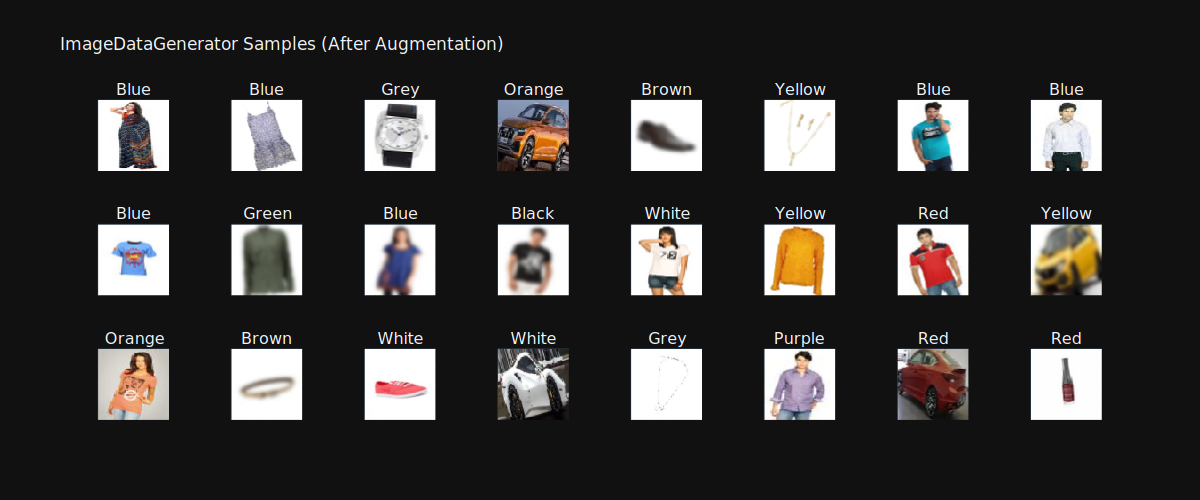

In [1283]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

print(f'Mode: {train_data.class_mode}')
print(f'Label (reference): {train_data.class_indices}')
num_class = len(train_data.class_indices)

def index_to_label(index):
    '''Translate class index to its real label'''
    # Binary: 0, 1, 2, ...
    # Categorical: (1 0 0), (0 1 0), (0 0 1), ...
    # Sparse (reference class): 0.0, 1.0, 2.0, ...
    # Sparse (prediction result): 0.1, 0.7, 0.2, ... (probability with sum = 1)
    if train_data.class_mode == 'categorical' or train_data.class_mode == 'sparse':
        if isinstance(index, np.ndarray): index = index.argmax()
    return list(train_data.class_indices)[int(index)]

# View the first N batch only
n_batch = 3
# View N images per batch
n_sample = 8

fig = make_subplots(
    rows = n_batch, cols = n_sample,
    subplot_titles = [f'{i}' for i in range(n_batch * n_sample)],
)

print('Label (samples): ', end = '')
for i in range(n_batch):
    # if i == 0: print(train_data.shape)
    view_batch = train_data[i]

    for j in range(n_sample):
        # batch[0] = list of image array
        image = view_batch[0][j]
        
        # batch[1] = list of label array
        label_index = view_batch[1][j]
        print(label_index, end = ', ')

        # Update temporary title
        label = index_to_label(label_index)
        fig['layout']['annotations'][i * n_sample + j]['text'] = label

        if rescale: image *= 255
        fig.add_trace(go.Image(z = image, name = f'{label}'), row = i + 1, col = j + 1)

fig.update_layout(title = f'ImageDataGenerator Samples (After Augmentation)')
fig.update_xaxes(showticklabels = False).update_yaxes(showticklabels = False)
fig.show(width = 1200) # renderer = 'vscode'

There are still some false positives, but whatever. It's not something that can be easily fixed.

In [1284]:
# In case the generator doesn't get reset automatically
train_data.reset()
val_data.reset()

## Model Training

Compute class weight first to balance the weight of minority classes.

In [1285]:
from sklearn.utils import class_weight

# https://stackoverflow.com/questions/42586475/
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes = np.unique(train_data.classes), 
    y = train_data.classes
)

class_weights = dict(zip(np.unique(train_data.classes), class_weights))
print(class_weights)

{0: 0.5384128591317555, 1: 0.6495648190563444, 2: 0.6658318985756769, 3: 1.4044239022779796, 4: 0.8247382706475378, 5: 2.9297520661157024, 6: 1.8296774193548386, 7: 1.8415584415584416, 8: 1.1203581775085594, 9: 0.8044629349470499, 10: 1.6386748844375962}


In [1286]:
continue_train = True

In [1287]:
# Prevent memory leak on repeated execution
keras.backend.clear_session()

if continue_train:
    # Load existing model (along with its weight)
    model = keras.models.load_model(f'{misc_dir}/model.tf')
    print('Loaded existing model!')
else:
    # https://keras.io/api/applications/
    # https://keras.io/guides/transfer_learning/
    base_model = keras.applications.EfficientNetV2B3(
        input_shape = (target_height, target_width, 3),
        include_preprocessing = False,
        include_top = False,
        # Max pooling may not be good for white background
        # However, some of my references also use max pooling
        pooling = 'max'
    )

    model = keras.models.Sequential([
        base_model,

        keras.layers.Dense(units = 256, name = 'dense_1'),
        keras.layers.PReLU(name = 'prelu_1'),
        keras.layers.Dropout(rate = 0.3, name = 'dropout_1'),
        
        keras.layers.Dense(units = num_class, activation = 'softmax', name = 'dense_2')
    ])

print('Number of layers:', len(model.layers))
model.summary() # expand_nested = True

Number of layers: 5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Function  (None, 1536)             12930622  
 al)                                                             
                                                                 
 dense_1 (Dense)             (None, 256)               393472    
                                                                 
 prelu_1 (PReLU)             (None, 256)               256       
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 11)                2827      
                                                                 
Total params: 13,327,177
Trainable params: 13,217,961
Non-trainable params: 109,216
__________________

In [1288]:
import pickle

logger = keras.callbacks.CSVLogger(
    filename = f'{misc_dir}/training.csv',
    append = False
)

checkpoint = keras.callbacks.ModelCheckpoint(
        filepath = f'{misc_dir}/model.tf',
        monitor = 'val_loss',
        save_best_only = True,
        save_weights_only = False,
        verbose = 1
    )

if continue_train:
    # Restore last checkpoint threshold
    with open(f'{misc_dir}/checkpoint.pkl', 'rb') as f: 
        checkpoint.best = pickle.load(f)

early_stop = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0,
    patience = 10,
    # No need if using checkpoint
    restore_best_weights = False,
    verbose = 1
)

class CheckMetrics(keras.callbacks.Callback):
    def __init__(self, metrics: str, threshold: float, mode: str):
        super().__init__()
        self.metrics = metrics
        self.val_metrics = 'val_' + metrics
        self.threshold = threshold
        self.mode = mode

    def on_epoch_end(self, epoch, logs: dict):
        met = logs.get(self.metrics)
        val_met = logs.get(self.val_metrics)

        if self.mode == 'max':
            condition = met >= self.threshold and val_met >= self.threshold
        else:
            condition = met <= self.threshold and val_met <= self.threshold

        if condition:
            print(f'Epoch {epoch + 1}: Reached {met} {self.metrics} and {val_met} {self.val_metrics}, stopping training')
            self.model.stop_training = True

check_metrics = CheckMetrics('acc', 92, 'max')

In [ ]:
model.compile(
    optimizer = keras.optimizers.Adamax(learning_rate = 0.001),
    # Make sure "from_logits = False" if using activation like softmax
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = [ keras.metrics.SparseCategoricalAccuracy(name = 'acc') ]
)

training = model.fit(
    train_data,
    epochs = 200,
    validation_data = val_data,
    # steps_per_epoch = 128,
    # validation_steps = 128,
    class_weight = class_weights,
    callbacks = [logger, checkpoint, check_metrics, early_stop]
)

Save/load the trained model.

In [1314]:
skip_train = False

In [1315]:
if not skip_train:
    with open(f'{misc_dir}/checkpoint.pkl', 'wb') as f:
        pickle.dump(checkpoint.best, f)
    # Easy backup when training on Kaggle
    shutil.make_archive('misc', 'zip', misc_dir)

if skip_train:
    model = keras.models.load_model(f'{misc_dir}/model.tf')

history = pd.read_csv(f'{misc_dir}/training.csv')

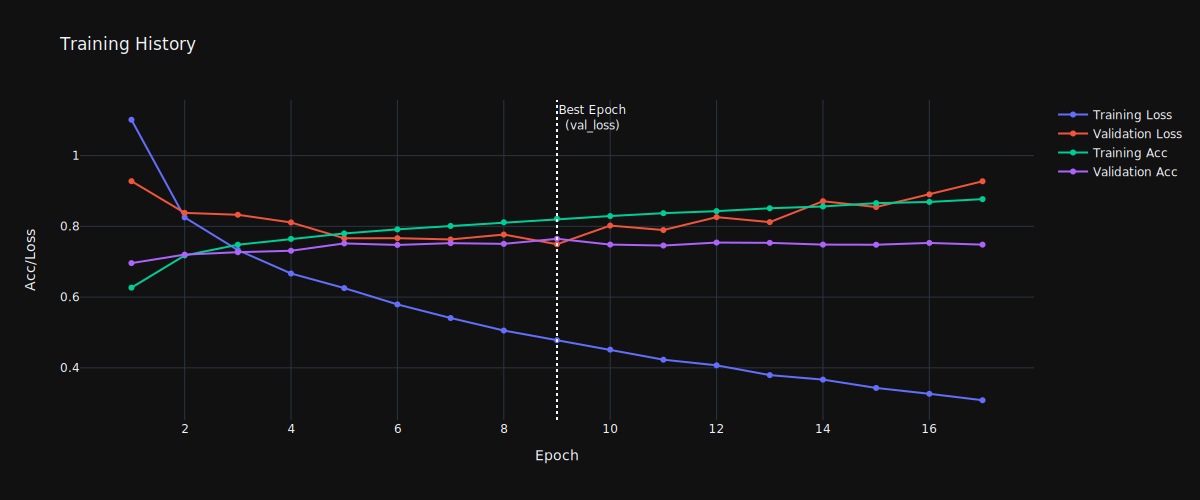

In [1316]:
import plotly.graph_objects as go

fig = go.Figure()

metrics = 'val_loss'
mode = np.argmin

fig.add_trace(
    go.Scatter(
        x = [ i + 1 for i in range(len(history['loss'])) ],
        y = history['loss'],
        name = 'Training Loss'
    )
)

fig.add_trace(
    go.Scatter(
        x = [ i + 1 for i in range(len(history['val_loss'])) ],
        y = history['val_loss'],
        name = 'Validation Loss'
    )
)

fig.add_trace(
    go.Scatter(
        x = [ i + 1 for i in range(len(history['acc'])) ],
        y = history['acc'],
        name = 'Training Acc'
    )
)

fig.add_trace(
    go.Scatter(
        x = [ i + 1 for i in range(len(history['val_acc'])) ],
        y = history['val_acc'],
        name = 'Validation Acc'
    )
)

fig.add_vline(
    x = mode(history[metrics]) + 1,
    line_dash = 'dot',
    annotation_text = f'Best Epoch<br>({metrics})'
)

fig.update_layout(
    # https://plotly.com/python/reference/layout/
    title = { 'text': f'Training History' },
    # https://plotly.com/python/reference/layout/xaxis/
    xaxis = { 'title': 'Epoch' },
    # https://plotly.com/python/reference/layout/yaxis/
    yaxis = { 'title': 'Acc/Loss' },
    hovermode = 'x unified',
    hoverlabel = { 'namelength': -1 }
)

fig.show(width = 1200)

Changelog:
- v1: Using Resnet50 v2, global max pooling, adam (0.005 learning rate). Acc and val_acc stagnated around 72%
- v2: Change to EfficientNetB3 v2, global avg pooling, adamax (0.001 learning rate). Combined data with vehicle color dataset and added median filter + gaussian blur preprocessing. Acc 88%, val_acc 75%
- v3: Continuing v2, changed generator seed from 1337 to 1234. Steps per epoch 320, validation steps 80. Accuracy still doesn't increase
- v4: Continuing v3, using mini-batch (32 samples per epoch), 2000 epoch. Accuracy still doesn't increase
- v5: Continuing v4, increased gaussian intensity (1.0 to 2.0) but lower the chance (0.5 to 0.3). Removed median filter since it doesn't do much. Accuracy still doesn't increase
- v6: Train again from scratch but with global max pooling and default batch size. Added 1 more dataset (Digikala fashion color) and simplified class category (maroon -> red, navy blue -> blue, etc), val_acc still stuck around 75%

Todo:
- Prediction and [recommender system](https://www.kaggle.com/code/marlesson/building-a-recommendation-system-using-cnn)
- Visualize layers with `visualkeras` or `tf-explain`
- Explore `skimage`, `imgaug`, and their filter options ([HOG](https://www.kaggle.com/code/anirbanmalick/image-classification-using-hog-knn-98-acc), canny, sobel, etc)
- Experiment with encoder & decoder ([reference](https://www.kaggle.com/code/ohseokkim/base-denoising-autoencoder-dimension-reduction))
- Recolorization ([reference](https://www.kaggle.com/code/basu369victor/image-colorization-basic-implementation-with-cnn))